## NYC Airbnb Dataset 

## Imports

In [1]:
!pip install xgboost

  Using cached xgboost-2.1.4-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached nvidia_nccl_cu12-2.25.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.8 kB)
Using cached xgboost-2.1.4-py3-none-manylinux_2_28_x86_64.whl (223.6 MB)
Using cached nvidia_nccl_cu12-2.25.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (201.4 MB)


In [38]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.9/543.9 kB 31.9 MB/s eta 0:00:00


In [39]:
import matplotlib.pyplot as plt
from IPython.display import Image, display
import os
import numpy as np
import pandas as pd
from sklearn.compose import (
    ColumnTransformer,
    TransformedTargetRegressor,
    make_column_transformer,
)
import shap
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVR
from sklearn.preprocessing import KBinsDiscretizer
import seaborn as sns
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import FunctionTransformer


## Introduction

The goal of this project is to exercise machine learning models, secure/clean data practices, as well as emphasizing data vizualization and data speaking. 

This project tackles a regression problem using [dataset](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data) of New York City Airbnb listings from 2019. Airbnb could use this sort of model to predict how popular future listing might be before they are posted, or to be uused as a guide for hosts to create more appealing listings. Vacancy rate or average rating could also be used as a target if more data was available. 

This project uses various different models + a baseline model in order to compare different methods of regression


## Preview

With 48895 rows and 16 columns, the data includes numerous data about Airbnb listings in New York, such as:
- Listing Information: id, name, host_id, host_name, neighbourhood_group, neighbourhood, latitude, longitude
- Room Characteristics: room_type, price, minimum_nights, availability_365
- Review Data: number_of_reviews, last_review, reviews_per_month
- Host Listings Count: calculated_host_listings_count
Using this dataset, we want to predict 'reviews_per_month', which we can use as a proxy for the popularity of the listing. As this is a numerical feature, the problem will need us to use regression techniques in order to predict how popular future listings might be before they are posted.

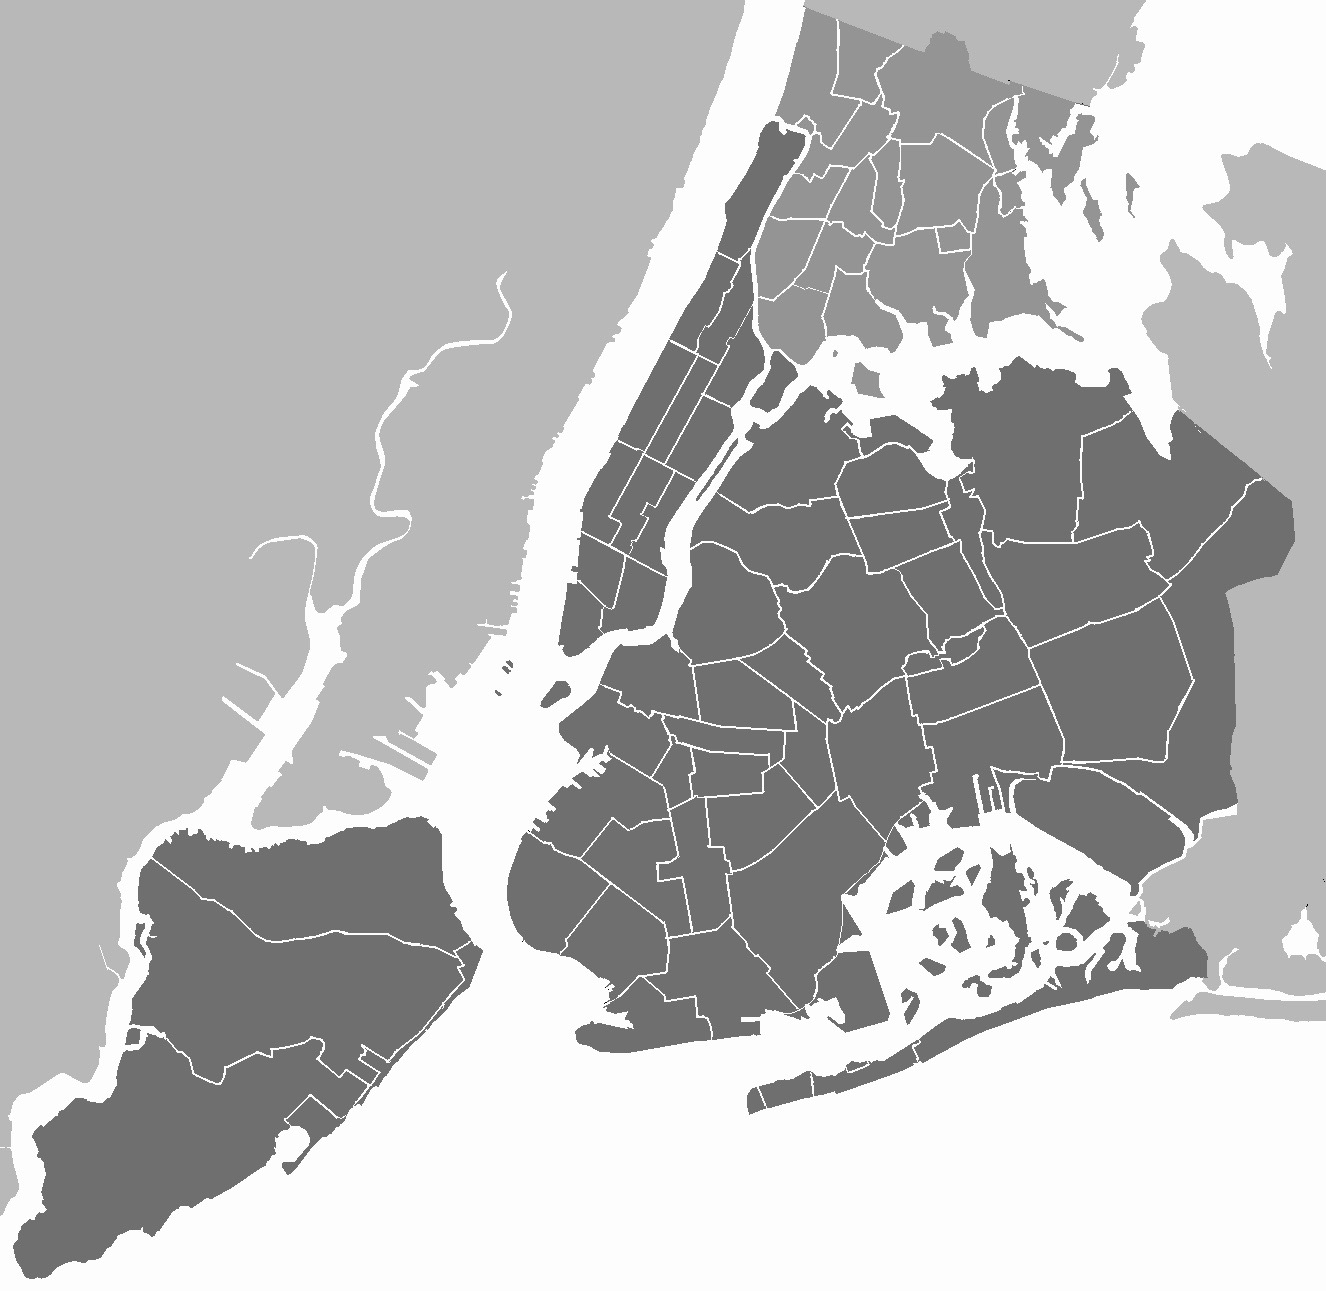

In [3]:
display(Image(filename='New_York_City_.png', width = 600))

In [4]:
df = pd.read_csv("AB_NYC_2019.csv")
df.count()

id                                48895
name                              48879
host_id                           48895
host_name                         48874
neighbourhood_group               48895
neighbourhood                     48895
latitude                          48895
longitude                         48895
room_type                         48895
price                             48895
minimum_nights                    48895
number_of_reviews                 48895
last_review                       38843
reviews_per_month                 38843
calculated_host_listings_count    48895
availability_365                  48895
dtype: int64

## Data Splitting 

We will split the data at a 70-30 train test split

In [5]:
X = df.drop(columns=['reviews_per_month'])
y = df['reviews_per_month']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 123)

## EDA
First, we will use sort_index() to check if we have any '?' values in our data as describe() and info() won't pick up '?' due to it being a string. We see that there are no '?', but we will execute the command to fill replace any '?' with NaN values just in case.

In [6]:
X_train.sort_index()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,6,365
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,1,0
6,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,2017-10-05,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48888,36484087,"Spacious Room w/ Private Rooftop, Central loca...",274321313,Kat,Manhattan,Hell's Kitchen,40.76392,-73.99183,Private room,125,4,0,NaN,1,31
48889,36484363,QUIT PRIVATE HOUSE,107716952,Michael,Queens,Jamaica,40.69137,-73.80844,Private room,65,1,0,NaN,2,163
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,1,27


In [7]:
X_train = X_train.replace("?", np.nan)
y_train = y_train.replace("?", np.nan)

We use describe() after to get a summary of our features. This also tells us what numerical variables there are, the range and typical values, as well as helping us decide what to keep or not to keep. In addition, using include = 'all' allows us to see categorical variables, extremely helpful in seeing the number of names there are.

In [8]:
X_train.describe(include = 'all')

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,calculated_host_listings_count,availability_365
count,3.422600e+04,34216,3.422600e+04,34209,34226,34226,34226.000000,34226.000000,34226,34226.000000,34226.000000,34226.000000,27236,34226.000000,34226.000000
unique,NaN,33662,NaN,9201,5,218,NaN,NaN,3,NaN,NaN,NaN,1676,NaN,NaN
top,NaN,Home away from home,NaN,David,Manhattan,Williamsburg,NaN,NaN,Entire home/apt,NaN,NaN,NaN,2019-06-23,NaN,NaN
freq,NaN,14,NaN,292,15176,2728,NaN,NaN,17848,NaN,NaN,NaN,984,NaN,NaN
mean,1.893979e+07,NaN,6.726273e+07,NaN,NaN,NaN,40.729142,-73.952083,NaN,151.528399,7.094957,23.244814,NaN,7.042453,112.526004
std,1.101332e+07,NaN,7.840511e+07,NaN,NaN,NaN,0.054531,0.046201,NaN,236.628392,21.548290,44.573323,NaN,32.590803,131.420031
min,2.539000e+03,NaN,2.438000e+03,NaN,NaN,NaN,40.506410,-74.244420,NaN,0.000000,1.000000,0.000000,NaN,1.000000,0.000000
25%,9.394482e+06,NaN,7.721897e+06,NaN,NaN,NaN,40.690193,-73.983030,NaN,69.000000,1.000000,1.000000,NaN,1.000000,0.000000
50%,1.954546e+07,NaN,3.074526e+07,NaN,NaN,NaN,40.723240,-73.955550,NaN,106.000000,3.000000,5.000000,NaN,1.000000,45.000000
75%,2.915085e+07,NaN,1.068375e+08,NaN,NaN,NaN,40.763287,-73.936270,NaN,175.000000,5.000000,23.000000,NaN,2.000000,225.750000


Next, we look at info() and isnull() + sum(). This tells us a lot about our data. Firstly, we et to see the data types for each feature. Secondly, we see through info() that there are some features that have a different amount of non-null values. This can be further explained by checking what features have null and the amount of null rows there are.

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34226 entries, 36150 to 15725
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              34226 non-null  int64  
 1   name                            34216 non-null  object 
 2   host_id                         34226 non-null  int64  
 3   host_name                       34209 non-null  object 
 4   neighbourhood_group             34226 non-null  object 
 5   neighbourhood                   34226 non-null  object 
 6   latitude                        34226 non-null  float64
 7   longitude                       34226 non-null  float64
 8   room_type                       34226 non-null  object 
 9   price                           34226 non-null  int64  
 10  minimum_nights                  34226 non-null  int64  
 11  number_of_reviews               34226 non-null  int64  
 12  last_review                     2

In [10]:
X_train.isnull().sum()

id                                   0
name                                10
host_id                              0
host_name                           17
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       6990
calculated_host_listings_count       0
availability_365                     0
dtype: int64

Below is a bar graph that shows us the room type and number of listing each room type has. This is useful as later on, we might see a different in reviews depending on what room type the Airbnb is. 

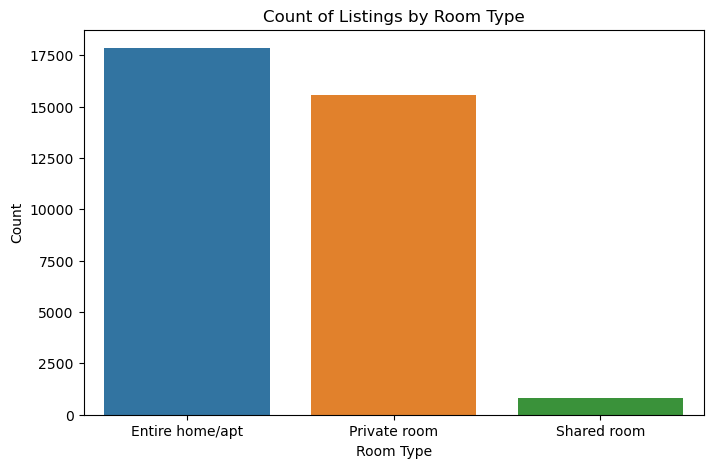

In [11]:
plt.figure(figsize=(8, 5))
sns.countplot(data=X_train, x='room_type', hue = 'room_type')
plt.title('Count of Listings by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Count')
plt.show()

Before when we used describe(), we saw that the mean price was low but the max was high. Visualizing the distribution of prices helps us understand the spread and typical values of price.

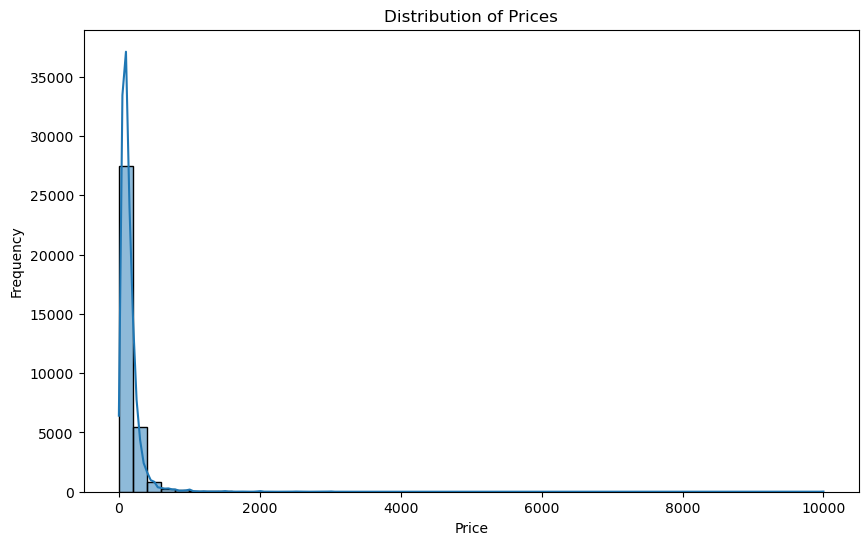

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(X_train['price'], bins=50, kde=True)
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

Let's do the same thing for our target variable: reviews_per_month. Once again we get a visualization to help understand the spread and typical number of reviews per month.



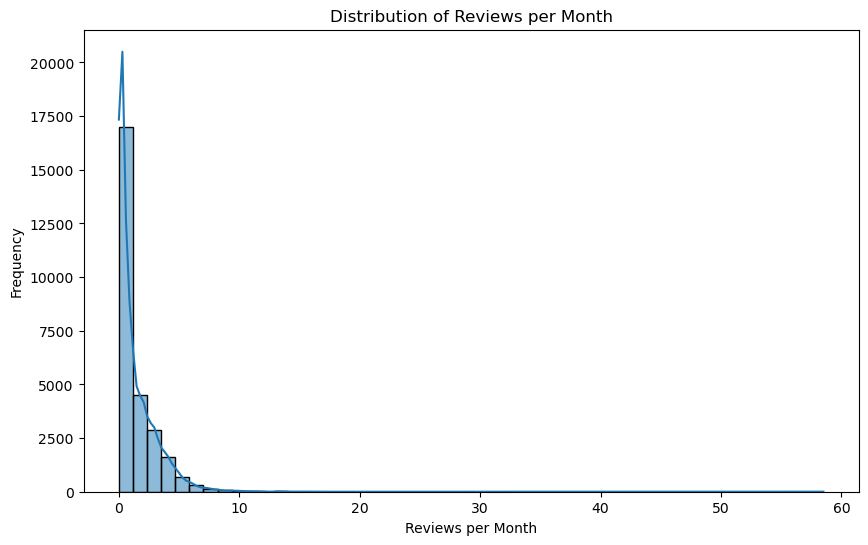

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(y_train, bins=50, kde=True)
plt.title('Distribution of Reviews per Month')
plt.xlabel('Reviews per Month')
plt.ylabel('Frequency')
plt.show()

What do we see overall? First, we clearly see that there are some features that have null values. This indicates that we will need to do some imputing or filling in of values in order to take care of these features. We also see that while a large amount of listings have a lower end of reviews_per_month or price, there are indeed some listings with high values of either or, so those could potentially be great examples of a good listing. Most importantly, we also see some features that are not useful for prediction at all. Most notably 'id', 'host_id','host_name', and 'last_review' are all irrelevant to our analysis.

'id', and 'host_id' are not related to the Airbnb listing at all but simply an identifier for the review user or the host iser, which does not effect number of reviews or Airbnb experience. While a certain host might have more reviews for their listings, there are numerous reasons why we should not add host_id. We want our model to be able to predict number of reviews for future listings, and in the future host id's may change or they may always be different, also future Airbnb hosts will have little power over their id, so it is not what they should focus on.

'host_name' is excluded as 'host_name' is the name of the host. We exclude the name of the host because there are over 9000 unique host names, and future host names could be unique as well, so it is not an indicator of whether there will be a review or not (as well as ethical reasons which is outside the scope of this project).

'last_review' is irrelevant because it indicates the date that the last review was posted, which has no meaningful impact on the number of reviews an Airbnb will have.

As our target variable reviews_per_month is a numerical variable, we will use Root Mean Squared Error as our metric. This is so our error will be in the same units, reviews, as our target variable. We will also use R^2 to further aid us in understanding our model.



## Data Engineering

One of the goals of this project is to utilize text processing for our model. Specifically, 'name' of the Airbnb is a variable that can differ in size and specification across all Airbnb's. To start, we will simply compare the length of the name and see if that has any relevance to our target variable.

In [14]:
def get_avg_word_length(text):
    """
    Returns the average word length of the given text.

    Parameters:
    text -- (str)
    """
    if isinstance(text, str):
        words = text.split()
        return sum(len(word) for word in words) / len(words) if words else 0
    else:
        return 0

X_train = X_train.assign(
    average_word_length=X_train["name"].apply(get_avg_word_length)
)
X_test = X_test.assign(average_word_length=X_test["name"].apply(get_avg_word_length))

## Preprocessing and Transformations
Now lets look at the data and see what transformers or preprocessing needs to be applied to which data types in order to define a column transformer.

In [15]:
X_train.describe(include= 'all')

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,calculated_host_listings_count,availability_365,average_word_length
count,3.422600e+04,34216,3.422600e+04,34209,34226,34226,34226.000000,34226.000000,34226,34226.000000,34226.000000,34226.000000,27236,34226.000000,34226.000000,34226.000000
unique,NaN,33662,NaN,9201,5,218,NaN,NaN,3,NaN,NaN,NaN,1676,NaN,NaN,NaN
top,NaN,Home away from home,NaN,David,Manhattan,Williamsburg,NaN,NaN,Entire home/apt,NaN,NaN,NaN,2019-06-23,NaN,NaN,NaN
freq,NaN,14,NaN,292,15176,2728,NaN,NaN,17848,NaN,NaN,NaN,984,NaN,NaN,NaN
mean,1.893979e+07,NaN,6.726273e+07,NaN,NaN,NaN,40.729142,-73.952083,NaN,151.528399,7.094957,23.244814,NaN,7.042453,112.526004,5.454134
std,1.101332e+07,NaN,7.840511e+07,NaN,NaN,NaN,0.054531,0.046201,NaN,236.628392,21.548290,44.573323,NaN,32.590803,131.420031,1.816349
min,2.539000e+03,NaN,2.438000e+03,NaN,NaN,NaN,40.506410,-74.244420,NaN,0.000000,1.000000,0.000000,NaN,1.000000,0.000000,0.000000
25%,9.394482e+06,NaN,7.721897e+06,NaN,NaN,NaN,40.690193,-73.983030,NaN,69.000000,1.000000,1.000000,NaN,1.000000,0.000000,4.555556
50%,1.954546e+07,NaN,3.074526e+07,NaN,NaN,NaN,40.723240,-73.955550,NaN,106.000000,3.000000,5.000000,NaN,1.000000,45.000000,5.250000
75%,2.915085e+07,NaN,1.068375e+08,NaN,NaN,NaN,40.763287,-73.936270,NaN,175.000000,5.000000,23.000000,NaN,2.000000,225.750000,6.000000


Next, we seperate the different variables that will need different transformers/

In [16]:
numeric_feats = ['price', 'minimum_nights', 'number_of_reviews',
                 'calculated_host_listings_count', 'availability_365', 'average_word_length']

discretization_feats = ['latitude', 'longitude']
categorical_feats = ['neighbourhood', 'neighbourhood_group', 'room_type']
text_feat = ["name"]
drop_feats = ['id', 'host_id', 'host_name', 'last_review']

In [17]:
numerical_transformer = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value = "missing"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False)
)

one_dim = FunctionTransformer(np.reshape, kw_args={'newshape':-1})

text_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value = "missing"),
    one_dim,
    CountVectorizer(max_features=100, stop_words="english",binary = True)
)

discretization_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    KBinsDiscretizer(n_bins=20, encode="onehot")
)
# To ensure proper type matching
X_train['name'] = X_train['name'].astype(str)

preprocessor = make_column_transformer(
    (numerical_transformer, numeric_feats),
    (categorical_transformer, categorical_feats),
    (discretization_transformer, discretization_feats),
    (text_transformer, text_feat),
    ("drop", drop_feats)
)

## Baseline model

Now that we have our preprocessor, let's try it out on `scikit-learn`'s baseline model and report results.

In [18]:
baseline = DummyRegressor(strategy="mean")
pipe_baseline = make_pipeline(preprocessor, baseline)

y_train_imputed = SimpleImputer(strategy = 'constant', fill_value = 0).fit_transform(pd.DataFrame(y_train))
y_test_imputed = SimpleImputer(strategy = 'constant', fill_value = 0).fit_transform(pd.DataFrame(y_test))

rmse_base = np.sqrt(abs(cross_val_score(pipe_baseline, X_train, y_train_imputed, scoring = 'neg_mean_squared_error').mean()))
print(rmse_base)
r2_base = (cross_val_score(pipe_baseline, X_train, y_train_imputed, scoring = 'r2').mean())
print(r2_base)

1.6145208647261136
-4.4095040527558635e-05


The baseline model returns an average RMSE of around 1.614 over 5 cross-validation folds. This means that our predictions have an average of around 1.614 reviews per month.

Futhermore, our average R^2 score is a negative number extremely close to 0! As DummyRegressor would generally not explain any variance, this makes sense.

Text(0, 0.5, 'predicted price')

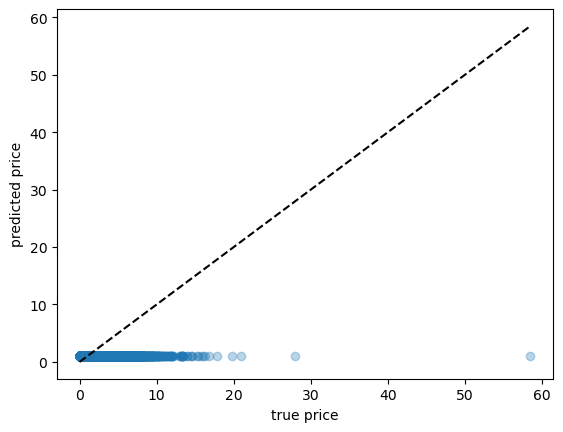

In [19]:
pipe_baseline.fit(X_train, y_train_imputed)
plt.scatter(y_train_imputed, pipe_baseline.predict(X_train), alpha=0.3)
grid = np.linspace(y_train_imputed.min(), y_train_imputed.max(), 10)
plt.plot(grid, grid, "--k")
plt.xlabel("true price")
plt.ylabel("predicted price")

We can see though that our DummyRegressor always chooses the mean of reviews per month. Let us try different models and see the improvement!

## Linear Models

First we will use a Ridge model for our linear model. We will look at our cross-validation scores and RMSE, R^2 without any hyperparameter tuning



In [20]:
ridge = Ridge(random_state = 123)
ridge_pipe = make_pipeline(preprocessor, ridge)
scores = cross_validate(ridge_pipe, X_train, y_train_imputed, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.965347,0.496948,0.415266,0.408255
1,1.096812,0.398359,0.404553,0.411069
2,0.999088,0.496235,0.336659,0.429764
3,1.097099,0.498168,0.418861,0.407487
4,0.998165,0.498242,0.412734,0.409281


In [21]:
rmse_ridge = np.sqrt(abs(cross_val_score(ridge_pipe, X_train, y_train_imputed, scoring = 'neg_mean_squared_error').mean()))
print(rmse_ridge)
r2_ridge = (cross_val_score(ridge_pipe, X_train, y_train_imputed, scoring = 'r2').mean())
print(r2_ridge)

1.254938823091012
0.39761447465592303


As we can see, our rmse has decreased a bit and our R^2 has improved greatly compared to DummyRegressor, but our test and train scores are quite low. Next, lets run hyperparameter tuning for Ridge's alpha.



In [22]:
scores_dict = {
    "alpha": 10.0 ** np.arange(-3, 6, 1),
    "mean_train_scores": list(),
    "mean_cv_scores": list(),
    "std_train_cv_scores": list(),
    "std_test_cv_scores": list(),
}
for alpha in scores_dict["alpha"]:
    pipe_ridge = make_pipeline(preprocessor, Ridge(alpha=alpha, random_state = 123))
    scores = cross_validate(pipe_ridge, X_train, y_train_imputed, return_train_score=True)
    scores_dict["mean_train_scores"].append(scores["train_score"].mean())
    scores_dict["mean_cv_scores"].append(scores["test_score"].mean())
    scores_dict["std_train_cv_scores"].append(scores["train_score"].std())
    scores_dict["std_test_cv_scores"].append(scores["test_score"].std())                                          

results_df = pd.DataFrame(scores_dict)

In [23]:
results_df

,alpha,mean_train_scores,mean_cv_scores,std_train_cv_scores,std_test_cv_scores
0,0.001,0.413335,0.396408,0.008373,0.030495
1,0.010,0.413335,0.396427,0.008373,0.030501
2,0.100,0.413332,0.396600,0.008373,0.030555
3,1.000,0.413171,0.397614,0.008383,0.030839
4,10.000,0.411613,0.399650,0.008439,0.031077
5,100.000,0.406078,0.399072,0.008384,0.030968
6,1000.000,0.391119,0.388708,0.008316,0.030406
7,10000.000,0.348301,0.348550,0.007669,0.027486
8,100000.000,0.148979,0.149410,0.003262,0.012116


By testing different alpha values, we are able to conclude a few things. First our overall training and test scores are on the low side. However, we have less concern on the fundamental trade-off as the difference between our training and testing is never too high. Perhaps different models will help our results?

## Different Models

Lets try three different models: DecisionTreeRegressor, XGBoost, and KNeighborsRegressor."

In [24]:
scoring = {
    'rmse': 'neg_root_mean_squared_error',
    'r2': 'r2'
}
d_tree = DecisionTreeRegressor(random_state = 123)
d_tree_pipe = make_pipeline(preprocessor, d_tree)
tree_scores = cross_validate(d_tree_pipe, X_train, y_train_imputed, return_train_score=True, scoring = scoring)
pd.DataFrame(tree_scores)

,fit_time,score_time,test_rmse,train_rmse,test_r2,train_r2
0,1.521957,0.083076,-1.363202,-4.273348e-05,0.279734,1.0
1,2.122308,0.080269,-1.370898,-1.347444e-18,0.275583,1.0
2,2.002431,0.079346,-1.495432,-1.351327e-04,0.230014,1.0
3,2.174779,0.080366,-1.405786,-1.351327e-04,0.194025,1.0
4,2.121723,0.078769,-1.403612,-1.351327e-04,0.212622,1.0


From our train and test scores from cross_validate, we see we have incredibly low train RMSE and high R^2. while we have comparatively higher test RMSE and much lower test RMSE This high difference indicates a large amount of overfitting, and the fit times are roughly three times higher than the linear model

In [26]:
xgb = XGBRegressor(random_state=123) 
xgb_pipe = make_pipeline(preprocessor, xgb)
xgb_scores = cross_validate(xgb_pipe, X_train, y_train_imputed.ravel(), return_train_score=True,scoring = scoring)
pd.DataFrame(xgb_scores)

,fit_time,score_time,test_rmse,train_rmse,test_r2,train_r2
0,2.649856,0.109754,-0.997291,-0.752321,0.614508,0.783419
1,2.477762,0.163081,-0.981553,-0.759888,0.628631,0.778737
2,2.545321,0.106910,-1.137644,-0.761964,0.554382,0.770718
3,2.540126,0.108376,-0.981630,-0.757236,0.607013,0.783235
4,2.566152,0.108543,-0.994516,-0.771292,0.604713,0.774036


A pleasant sight to see is that using XGBRegressor, our test and train score (in the context of this cross-validation, one could say train and validation score) went up. There is a smaller gap between the train and test score here compared to the decision tree, but still a large gap (up to 0.22) so overfitting is a possibility. Fit time is about as much as Ridge.

In [27]:
knear = KNeighborsRegressor()
knear_pipe = make_pipeline(preprocessor, knear)
knear_scores = cross_validate(knear_pipe, X_train, y_train_imputed, return_train_score = True, scoring = scoring)
pd.DataFrame(knear_scores)

,fit_time,score_time,test_rmse,train_rmse,test_r2,train_r2
0,0.369917,6.142479,-1.295463,-1.072572,0.349538,0.559784
1,0.369496,6.036749,-1.316006,-1.076511,0.332434,0.555936
2,0.472873,5.995852,-1.412596,-1.043154,0.312954,0.570268
3,0.401826,5.910027,-1.259052,-1.078273,0.353498,0.560475
4,0.367136,5.856439,-1.291935,-1.070245,0.332931,0.564921


Using KNeighborsRegressor, our fit time is much shorter than using Ridge. On the other hand, score time is incredibly long, up to 10x longer than ridge. Not only that, but test_rmse is larger than ridge and larger that train_rmse, while there is a moderate gap between test and train R^2. It seems that KNeighborsRegressor, while fitting fast, may not be the best model for our question today, and has a possiblility of overfitting.

## Feature Selection
We will now make an attempt to select relevant features using RFECV

In [28]:
rfecv = RFECV(estimator=ridge, step=1, cv=StratifiedKFold(5), scoring='neg_mean_squared_error')
rfecv_pipe = make_pipeline(preprocessor, rfecv, ridge)
rfecv_scores = cross_validate(ridge_pipe, X_train, y_train_imputed, return_train_score=True)
pd.DataFrame(rfecv_scores)

,fit_time,score_time,test_score,train_score
0,0.986798,0.495423,0.415266,0.408255
1,0.999377,0.496001,0.404553,0.411069
2,0.998030,0.497241,0.336659,0.429764
3,0.998790,0.497694,0.418861,0.407487
4,0.999323,0.496144,0.412734,0.409281


Feature Selection for the ridge model had little to no change in our results. One could even say the the fit time increased. What about a model based feature selection, which chooses features based on feature importances?

In [29]:
from sklearn.feature_selection import SelectFromModel

select_rf = SelectFromModel(
    Ridge(random_state=123), 
    threshold="median"
)
pipe_model_based = make_pipeline(preprocessor, select_rf, ridge)
mode_scores = cross_validate(pipe_model_based, X_train, y_train_imputed, return_train_score=True)
pd.DataFrame(mode_scores)

,fit_time,score_time,test_score,train_score
0,1.383420,0.398907,0.405226,0.394527
1,1.501575,0.399587,0.391679,0.397786
2,1.697013,0.498320,0.322831,0.416112
3,1.596373,0.499328,0.404240,0.391670
4,1.496865,0.498360,0.404907,0.393810


Using SelectFromModel, fit and score time bth increased with no drastic change in train or test score. Overall, we won't keep the feature selection in our pipeline.

## Hyperparameter Optimization

To optimize hyperparameters for the models we have tried, first we need to name each of the transformers so they can be more easily accessed. Afterwords, we will try to optimize our parameters for our DecisionTreeRegressor and further optimize our RidgeRegressor.

In [30]:
from sklearn.model_selection import RandomizedSearchCV

preprocessor_named = ColumnTransformer([
    ("num", numerical_transformer, numeric_feats),
    ("cat", categorical_transformer, categorical_feats),
    ("disc", discretization_transformer, discretization_feats),
    ("text", text_transformer, text_feat),
    ("drop", "drop", drop_feats)]
)

param_dist = {
    'columntransformer__text__countvectorizer__max_features': [100, 200, 400, 800, 1000, 2000],
    'decisiontreeregressor__max_depth': [1, 10, 50, 100],
    'decisiontreeregressor__min_samples_split': [2, 5, 10],
    'decisiontreeregressor__max_features': [1, 10, 'sqrt', 'log2']
}

d_tree_pipe_named = make_pipeline(preprocessor_named, d_tree)

random_search = RandomizedSearchCV(
    estimator=d_tree_pipe_named,
    param_distributions=param_dist,
    n_iter=50,  
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=123,
    n_jobs=-1 
)

random_search.fit(X_train, y_train_imputed)

print("Best Parameters:", random_search.best_params_)
print("Best RMSE:", np.sqrt(-random_search.best_score_))
rmse_d_tree = np.sqrt(abs(cross_val_score(d_tree_pipe, X_train, y_train_imputed, scoring = 'neg_mean_squared_error').mean()))
print("Previous RMSE:", rmse_d_tree)

Best Parameters: {'decisiontreeregressor__min_samples_split': 5, 'decisiontreeregressor__max_features': 'sqrt', 'decisiontreeregressor__max_depth': 10, 'columntransformer__text__countvectorizer__max_features': 100}
Best RMSE: 1.3820670669303334
Previous RMSE: 1.4085706915557554


In [31]:
pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_columntransformer__text__countvectorizer__max_features", 
        "param_decisiontreeregressor__max_depth",
        "param_decisiontreeregressor__min_samples_split",
        "param_decisiontreeregressor__max_features",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
mean_test_score,-1.910109,-1.969148,-2.026659,-2.036746,-2.061466,-2.106601,-2.142263,-2.153829,-2.170209,-2.203907,...,-2.606483,-2.606483,-2.606505,-2.636659,-2.649566,-2.836166,-2.903441,-3.001106,-3.089524,-3.329128
param_columntransformer__text__countvectorizer__max_features,100,100,2000,100,800,400,2000,2000,400,100,...,2000,2000,1000,2000,1000,2000,200,1000,100,100
param_decisiontreeregressor__max_depth,10,10,50,50,10,50,50,100,10,50,...,1,1,1,100,50,100,50,100,50,100
param_decisiontreeregressor__min_samples_split,5,10,10,5,10,10,5,10,2,10,...,10,5,2,5,2,2,2,2,2,2
param_decisiontreeregressor__max_features,sqrt,sqrt,sqrt,sqrt,sqrt,sqrt,sqrt,sqrt,sqrt,10,...,log2,10,1,1,10,1,1,log2,1,1
mean_fit_time,0.446067,0.448733,0.579685,0.507204,0.417458,0.64262,0.65856,0.696353,0.540804,0.463582,...,0.422766,0.414162,0.408043,0.482621,0.620299,0.560498,0.462646,1.034307,0.452445,0.504677


In this case, we tested multiple hyperparameters for the DecisionTreeRegressor, combined with optimizing CountVectorizer. From the results, we can see our RMSE has increases from our inital DecisionTreeRegressor using default parameters. THis could be choosing a bad range of values or due to random variablility.

In [32]:
ridge_pipe_named = make_pipeline(preprocessor_named, ridge)
param_dist1 = {
    'columntransformer__text__countvectorizer__max_features': [100, 200, 400, 800, 1000, 2000],
    'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

random_search_ridge = RandomizedSearchCV(
    estimator=ridge_pipe_named,
    param_distributions=param_dist1,
    n_iter=42,  
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=123,
    n_jobs=-1 
)

random_search_ridge.fit(X_train, y_train_imputed)

print("Best Parameters:", random_search_ridge.best_params_)
print("Best RMSE:", np.sqrt(-random_search_ridge.best_score_))
rmse_ridge = np.sqrt(abs(cross_val_score(ridge_pipe, X_train, y_train_imputed, scoring = 'neg_mean_squared_error').mean()))
print("Previous RMSE:", rmse_ridge)

Best Parameters: {'ridge__alpha': 10, 'columntransformer__text__countvectorizer__max_features': 2000}
Best RMSE: 1.24366516671166
Previous RMSE: 1.254938823091012


For our linear model, RSME decreased slightly after tuning hyperparameters. Most notably, CountVectorizer was optimized to have 2000 max features instead of 100, which given the size of the dataset and various names, seems to have helped optimize our model.

## Interpretation and Feature Importances
Let's choose DecisionTreeRegressor as our non-linear model and take a look at it's feature importances

In [33]:
feature_names = []
preprocessor.named_transformers_
ohe_feature_names = (
    d_tree_pipe.named_steps["columntransformer"]
    .named_transformers_["pipeline-2"]
    .named_steps["onehotencoder"]
    .get_feature_names_out(categorical_feats)
    .tolist()
)
kbins_feature_names = (
    d_tree_pipe.named_steps["columntransformer"]
    .named_transformers_["pipeline-3"]
    .named_steps["kbinsdiscretizer"]
    .get_feature_names_out(discretization_feats)
    .tolist()
)
text_feature_names = (
    d_tree_pipe.named_steps["columntransformer"]
    .named_transformers_["pipeline-4"]
    .named_steps["countvectorizer"]
    .get_feature_names_out(text_feat)
    .tolist()
)
feature_names = (
    numeric_feats + ohe_feature_names + kbins_feature_names + text_feature_names
)

In [34]:
X_train_transformed = preprocessor.fit_transform(X_train)

d_tree.fit(X_train_transformed, y_train_imputed)
feature_importances = d_tree.feature_importances_
if len(feature_importances) == len(feature_names):
    importances_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by="Importance", ascending=False)

    print(importances_df.head(10))

                            Feature  Importance
2                 number_of_reviews    0.435958
1                    minimum_nights    0.090884
4                  availability_365    0.085769
0                             price    0.031193
5               average_word_length    0.030094
299                            city    0.022355
196  neighbourhood_Theater District    0.018758
3    calculated_host_listings_count    0.013059
227      neighbourhood_group_Queens    0.007784
65      neighbourhood_East Elmhurst    0.006806


The top ten features show us many key details. First, there are over 300 features that this model uses. This is surely due to the countvectorizer and onehotencoder creating seperate features. Secondly, the feature with the most importance is number_of_reviews, with a staggering 0.436 importance while the second most important feature, minimum_nights, is at 0.091. In a DecisionTree, it is not linear so we cannot say whether the feature will decrease or increase the reviews_per_month, but we can say that a high proportion of the steps is dependant on this feature. Additionally, since there are so many features and many featuers with a small amount of importance, there is a possibilty of overfitting for this decisiontree.



## Results on the test set
Our best performing model is XGBoost, so let's use that to get test scores.

In [35]:
xgb = XGBRegressor(random_state=123) 
xgb_pipe = make_pipeline(preprocessor, xgb)
xgb_pipe.fit(X_train, y_train_imputed)
y_pred_test = xgb_pipe.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test_imputed, y_pred_test))
r2_test = r2_score(y_test_imputed, y_pred_test)

print(f"Test RMSE: {rmse_test}")
print(f"Test R^2: {r2_test}")

Test RMSE: 1.0010935039311808
Test R^2: 0.5862229056978132


Let's also recall our validation scores

In [36]:
pd.DataFrame(xgb_scores).mean()

fit_time      2.555844
score_time    0.119333
test_rmse    -1.018527
train_rmse   -0.760540
test_r2       0.601849
train_r2      0.778029
dtype: float64

In the above table, let's refer to 'test_rmse' as our validation score. In this case, we can see that the validation RMSE average to an absolute value of 1, which is incredibly similar to our actual test score above. However, our validation R^2 (test_r2) is a bit higher than our test R^2, but only by a small, up to 0.04 amount. Overall, our validation scores are close to our test scores which means our model is working as expected. In terms of trust, we never looked too far ahead into the data which would lead into any data leakage and mistrust. The most likely issue of optimization bias we could have has is hyperparameter tuning, but that would only happen if we used the decision tree regressor above. Since our test scores were quite similar to our validation scores, there is lower chance of optimization bias.

In [40]:
shap.initjs()
feature_names = []
preprocessor.named_transformers_
ohe_feature_names = (
    xgb_pipe.named_steps["columntransformer"]
    .named_transformers_["pipeline-2"]
    .named_steps["onehotencoder"]
    .get_feature_names_out(categorical_feats)
    .tolist()
)
kbins_feature_names = (
    xgb_pipe.named_steps["columntransformer"]
    .named_transformers_["pipeline-3"]
    .named_steps["kbinsdiscretizer"]
    .get_feature_names_out(discretization_feats)
    .tolist()
)
text_feature_names = (
    xgb_pipe.named_steps["columntransformer"]
    .named_transformers_["pipeline-4"]
    .named_steps["countvectorizer"]
    .get_feature_names_out(text_feat)
    .tolist()
)
feature_names = (
    numeric_feats + ohe_feature_names + kbins_feature_names + text_feature_names
)
X_test_transformed = preprocessor.transform(X_test)
explainer = shap.Explainer(xgb, X_test_transformed)
shap_values = explainer(X_test_transformed)
if isinstance(shap_values, shap.Explanation):
    shap_values_array = shap_values.values
else:
    shap_values_array = shap_values


 97%|=================== | 14160/14669 [00:27<00:00]       

Lets take a look at the first prediction using a SHAP for plot, which will show us how each value contributes to the prediction compared to the average prediction.

In [41]:
shap.force_plot(
    explainer.expected_value, shap_values_array[0], X_test_transformed[0], feature_names=feature_names
)

So for our first prediction, we can see that the feature price pushed the models prediction down by -0.4925, which is a higher value that the average amount the feature would affect the prediction. For number_of_reviews, it pushed the models prediction by -0.5215, which is lower than what it normally would push.

In [42]:
shap.force_plot(
    explainer.expected_value, shap_values_array[1], X_test_transformed[1], feature_names=feature_names
)


Above is the force SHAP plot for the second prediction. Seeing an additional observation illustrates how our model changes predictions based on the feature values. We see that number_of_reviews for this observations instead pushed the models prediction by 2.507, which is much higher than how it would on average.

## Summary and Results 
This project used multiple aspects of machine learning in order to optimize model selection, hyperparameters, and features in order to predict the reviews_per_month for Airbnb's in NYC. We looked at linear and non-linear models to see which produces the highest average validation score, and conducted feature selection as an attempt to improve model interpretibility.

In conclusion, our model using XGBoost was able to predict the number of reviews_per_month with a final RMSE of around 1 review per month. We can further explain this by looking at the R^2 score, which is around 0.58, indicating that our model only explains 58% of the variability of the new data. Therefore, while the RMSE is on the lower end, it may be too simple and not capture complex relationships in the NYC Airbnb dataset.

For future improvments, we could add additional hyperparameter optimization for our XGBoost (using a computer which can run it) in order to increase model complexity. Furthermore, while we transformed the latitude and longitude features into bins which can aid in interpretibility, we could instead transformed these features into how close an Airbnb is to popular landmarks in NYC (Empire State building, Parks) which is more beneficial than reading bins of longitude and latitude.

Below will be a summary table that uses the values generated from the XGBoost validation tests, as well as the final test set. Thank you for reading this up until now!

In [43]:
data = {
    "Metric": [
        "Root Mean Squared Error (RMSE)", 
        "R-Squared (R²)", 
        "Top Features"
    ],
    "Cross-Validation Score": [
        "1.018527",   
        "0.601849",   
        "number_of_reviews, minimum_nights,"       
    ],
    "Test Score": [
        "1.00109",  
        "0.5862",   
          "availability_365"
    ],
    "Comments": [
        "Evaluated to measure prediction error", 
        "Variance explained by the model on test data",
        "Most impactful features on model predictions"
    ]
}

summary_table = pd.DataFrame(data)
summary_table

,Metric,Cross-Validation Score,Test Score,Comments
0,Root Mean Squared Error (RMSE),1.018527,1.00109,Evaluated to measure prediction error
1,R-Squared (R²),0.601849,0.5862,Variance explained by the model on test data
2,Top Features,"number_of_reviews, minimum_nights,",availability_365,Most impactful features on model predictions
